# The Art and Science of Data Matching

## Mike Mull (@kwikstep)

## Applications of Matching: Integration

<img src="Integrate.png">

I'll start with a few applications for data matching.

The first is _data integration_.  Here we are starting with multiple data sources with references to the same type of entities.  What we hope to end up with is a combined set of data for those entities that is more accurate and as timely as possible.  We also retain some sort of reference to the original data so that we don't lose any information.

## Applications of Matching: Enrichment

<img src="Enrich.png">

The second application is _enrichment_.  There are various ways this term is used, but as a data matching problem it usually means that you have a source of data, often from a client, that needs to be matched to a more complete and accurate set.  All or part of the more complete set is returned to the client as an enriched entity reference.

## Applications of Matching: Record Linking

<img src='Merge.png'>

The third application is called _record linkage_ or sometimes merging. In this scenario there are two sets of data that have references to the same type of entity, but also related statistics or facts about those entities.  The combined data can then be used to make correlations.  I'll use an application like this throughout this talk, which i'll discuss below.

## Pairwise Matching


If you have two sets of data items, A and B, each with no duplicates then 

- All possible record pairs are
$$
A \times B
$$
- The pairs can be divided into


$$
M=\{ (a,b)| a \in A, b \in B, a = b \}
$$

$$
U=\{ (a,b)| a \in A, b \in B, a \ne b \} \\
$$


By definition the union of the two sets M and U is the set of all pairs A and B, or:

$$
A \times B = M \cup U
$$


I will use the concept of pairwise matching throughout the code as a model to explain various techniques.  The essential idea is that given two sets of records (say, as two files), matching involves examining every possible record pair to determine if they refer to the same entity.  What we're usually interested in is the _M_ set above.  In practice:

- The M set is *much* smaller than the U set
- We generally __won't__ look at all of the pairs, which is |A||B| and is often a huge number
- We will make two types of errors.  We will put actual matches in U and we will put non-matches in M.
- Ideally the set of matches is transitive, but some techniques don't always get that result
- In the deduplication case, the M set contains the duplicates.  Finding all of the record pairs that belong to the same entity might require extra clustering.

Note that this model does not necessarily match the architecture of matching software.  In other words, we won't usually load the data sets all at once and work through the pairs.  We might, for example, load one set of data, use some properties of those records to query against an existing database that we want to match.

## Test Case

- From [On Wages and Hygiene: Surfacing Bad Management in Public Data](http://blog.enigma.io/bad-management-radiates-a-look-at-hygiene-and-wages/)
  - Florida restaurant inspection data
  - Federal wage compliance data (from DOL)

In [3]:
from IPython.display import HTML
import pandas as pd
# Wage data, drop everything but unique name and addresses, and filter to only Florida.
df_oge = pd.read_csv('./data/ogesdw.whd.whisard.fl.csv')

# Florida restaurant inspection data.  Drop everything but unique name and addresses
df_fl = pd.read_csv('./data/fl.restaurant-inspections.csv')

C:\Users\mike\Anaconda\envs\matching\lib\site-packages\IPython\core\interactiveshell.py:2902: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The data sets that i'll use come from a blog post by Enigma.io.  They used restaurant inspection data from the state of Florida, and wage data from the DOL to do an analysis of whether the wage violations are correllated to bad restaurant hygiene.  They concluded that restaurants with violations for improperly paying employees are much more likely to also have health violations.  One note, they used geocoded addresses to do the matching, whereas i'm primarily going to use street numbers just to illustrate certain ideas.

The first step in matching is usually to explore the data.  In this case we'll use _pandas_, which is often the tool of choice for this type of work in the Python world.  This process is becoming more automated these days, but since it's usually a one-time investment, it's still useful to do manually.  The type of exploration i'll do is an aspect of _data profiling_, although in this case we're mostly interested in qualitative features of the data like the number of null values or format patters, while profiling in generals also refers to checking numeric ranges, distributions and variance.

Of course, in the matching case we're also looking for attributes that might be similar between data sources so that we can use them for comparison.

## Data Exploration and Profiling

In [4]:
df_fl.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130643 entries, 0 to 130642
Data columns (total 83 columns):
district                                        130643 non-null object
county_number                                   130643 non-null int64
county_name                                     130643 non-null object
license_type_code                               130643 non-null int64
license_number                                  130643 non-null int64
dba                                             130613 non-null object
location_address                                130643 non-null object
location_city                                   130642 non-null object
location_zip_code                               130633 non-null object
inspection_number                               130643 non-null int64
visit_number                                    130643 non-null int64
inspection_class                                130643 non-null object
inspection_type                           

Here i've used the pandas dataframe method _info()_ to show all of the fields, the field types, and the number of non-null values.  Obviously, this data has a bunch of columns related to the inspection of restaurants.  There also clues here that restaurants will appear in this data more than once (inspection number, inspection date).  What we want for matching is to boil this down to the fields that might help us identify the restaurant and match it to other data sources.

In [5]:
fields = ['dba', 
          'location_address', 
          'location_city', 
          'location_zip_code',
          'district',
          'county_number']
df_fl_a = df_fl[fields].drop_duplicates()
df_fl_a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53578 entries, 0 to 130642
Data columns (total 6 columns):
dba                  53558 non-null object
location_address     53578 non-null object
location_city        53577 non-null object
location_zip_code    53570 non-null object
district             53578 non-null object
county_number        53578 non-null int64
dtypes: int64(1), object(5)
memory usage: 2.9+ MB


This code basically takes the fields that identify the restaurant and drops the exact duplicates.  We are left with about 54k entities. About 20 of them are missing names, which will make it difficult to match them.

In [6]:
df_oge_a_fl = df_oge[['trade_nm', 
                      'legal_name', 
                      'street_addr_1_txt', 
                      'cty_nm', 
                      'st_cd', 
                      'zip_cd',
                      'naic_cd']].drop_duplicates()
df_oge_a_fl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16683 entries, 0 to 16702
Data columns (total 7 columns):
trade_nm             16683 non-null object
legal_name           16593 non-null object
street_addr_1_txt    16683 non-null object
cty_nm               16683 non-null object
st_cd                16683 non-null object
zip_cd               16683 non-null float64
naic_cd              16676 non-null object
dtypes: float64(1), object(6)
memory usage: 1.0+ MB


This is the equivalent operation for the wage data.  We can see that both sources have a name field and various address fields, which are mostly (but not entirely) non-null.  Note here that the zip code field is described as a float, which means that every value in the input data is numeric.

### Use `apply()` and `groupby()` To Check Field Patterns

In [7]:
t={ord(x): y for (x, y) in zip('0123456789', '9999999999')}

def zip_trans(z): return str(z).translate(t) if pd.notnull(z) else z

df_fl_a['zip_code_pattern'] =  df_fl_a.location_zip_code.apply(zip_trans)
print(df_fl_a.groupby('zip_code_pattern').size())
df_oge_a_fl['zip_code_pattern'] = df_oge_a_fl.zip_cd.apply(zip_trans)
print(df_oge_a_fl.groupby('zip_code_pattern').size())

zip_code_pattern
99999         47780
99999-9999     1611
999999999      4179
dtype: int64
zip_code_pattern
99999.9    16683
dtype: int64


Certain types of identifiers have an expected format, but very often that format is not followed especially when the data was originally entered by hand.  Zip codes for instance have two correct formats (5 digit and zip+4), and obviously numerous potential wrong formats.  Here's a handy trick for looking for formats of fields that are all or mostly numeric (zips, SSN, employer id numbers, phone numbers, etc.)

Note here that the zip code pattern for the wage data looks like a decimal number.  That's because pandas defaults to float64 for numeric data.  This really means that the data is consistently a 5 digit integer.  If you know your zip codes, this also tells us that there are no zips with leading zeros, which isn't surprising since these data are filtered to locations in Florida.

### Use `apply()` With Regex

In [8]:
import re
def leading_patt(s):
    p = (('^[A-Z][a-z]', 'Aa'), ('^[A-Z][A-Z]', 'AA'), ('^[0-9][0-9]', '99'))
    for rx, patt in p:
        if re.search(rx, s):
            return patt
    return 'OTHER'

df_oge_a_fl = df_oge[['trade_nm', 
                      'legal_name', 
                      'street_addr_1_txt', 
                      'cty_nm', 
                      'st_cd', 
                      'zip_cd',
                      'naic_cd']].drop_duplicates()

df_oge_a_fl['leading_pattern'] = df_oge_a_fl.trade_nm.apply(leading_patt)
df_oge_a_fl.groupby('leading_pattern').size()

leading_pattern
99          37
AA        1133
Aa       14716
OTHER      797
dtype: int64

Sometimes you'll want to identify more complex patterns like email addresses or dates using regular expressions.  Here's a slightly contrived example where i'm looking at the leading pattern in the names of the businesses in the wage data.

### Look for Duplicates

In [9]:
from IPython.display import HTML, Javascript
df=df_fl_a.groupby(['dba','location_zip_code'])\
       .filter(lambda x: len(x['dba']) > 2)\
       .sort_values(by='dba')[['dba',
                     'location_address',
                     'location_city',
                     'location_zip_code',
                     'district', 
                     'county_number']].head(10)
HTML(df.to_html(classes='mark_rows'))

,dba,location_address,location_city,location_zip_code,district,county_number
87996,ATLANTIC VENDORS INC,2411 S ATLANTIC AVE,DAYTONA BCH SHORES,32118,D4,74
88045,ATLANTIC VENDORS INC,2209 S ATLANTIC AVE,DAYTONA BCH SHORES,32118,D4,74
88061,ATLANTIC VENDORS INC,2125 S ATLANTIC AVE,DAYTONA BCH,32118,D4,74
88291,ATLANTIC VENDORS INC,2209 S ATLANTIC AVE,DAYTONA BEACH SHORES,32118,D4,74
87993,ATLANTIC VENDORS INC,3111 S ATLANTIC AVE,DAYTONA BEACH SHORES,32118,D4,74
88474,ATLANTIC VENDORS INC,1615 S ATLANTIC AVE,DAYTONA BEACH,32118,D4,74
88493,ATLANTIC VENDORS INC,2500 N ATLANTIC AVE,DAYTONA BEACH,32118,D4,74
88502,ATLANTIC VENDORS INC,103 S OCEAN AVE,DAYTONA BEACH,32118,D4,74
87994,ATLANTIC VENDORS INC,2225 S ATLANTIC AVE,DAYTONA BCH SHORES,32118,D4,74
87997,ATLANTIC VENDORS INC,3125 S ATLANTIC AVE,DAYTONA BCH SHORES,32118,D4,74


We eliminated _exact_ duplicates above, but there might still be duplicate businesses in the data that have slight variations in address or name.  Here's an example, where i group by the name and zip code, and then filter groups with more than 2 items.  The highlighted rows are very likely to be duplicates.  They vary only in the spelling of the city name.

In [10]:
Javascript('''$('.mark_rows tbody tr').filter(':eq(7)')
                                             .css('background-color', '#CCCCCC');
              $('.mark_rows tbody tr').filter(':eq(8)')
                                             .css('background-color', '#CCCCCC');
                   ''')

<IPython.core.display.Javascript object>

### Make a Histogram of String Length

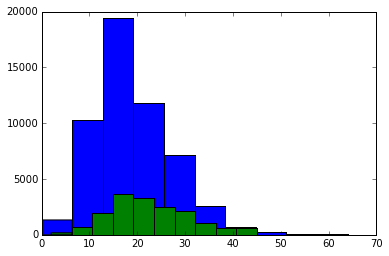

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

_ = plt.hist(df_fl_a.dba.apply(lambda x: len(x) if pd.notnull(x) else 0))
_ = plt.hist(df_oge_a_fl.trade_nm.apply(lambda x: len(x) if pd.notnull(x) else 0))

It's also easy to make plots of aggregated or transformed data.  Here's a simple example where i plot histograms of the lengths of the business names in our matching data.

## Comparing Fields

- What we want:

$$
IsMatch: A \times B \to \{\mathrm{true},  \mathrm{false}\}
$$

- In practice we compare against attributes of rA or rB to create a _comparison vector_

$$
Sim(r_{A}, r_{B}) = Sim(a_{1}, a_{2}..., a_{n}; b_{1}, b_{2}, ..., b_{n}) \\
= [s_{1}(a_{1}, b_{1}), ..., s_{n}(a_{n}, b_{n})]
$$

- Then create a decision model to classify comparison as match or non-match

What we've seen in profiling the data is that there are certain fields in each data source that we can compare for equality or similarity.  What we really want is a function that will take any record pair and tell us if they are a match.  We could do that by limiting ourselves to cases where the attributes in each record are identical, but that would miss a lot of matches.

The usual procedure is that we compare the two records attribute-by-attribute and end up with a _comparison vector_.  The comparison vector is then used in some sort of decision model or rule to decide if the pair is a match.  The next section will be about preprocessing fields to make them more easy to compare, and ways to measure similarity between various types of data.

### Preprocessing and Transformation

- Simple text transformations: lowerize, remove punctuation
- More complex:
  - Replace patterns ('&' -> 'and')
  - Standardize abbreviations, roman numerals, ordinals
  - In some situations, remove stop words, use stemming
  
<span style="font-size:14pt;color:blue;">POMODOROS PIZZA & SUBS & MORE II CORP -> pomodoros pizza and subs and more 2 corporation</span>

- Standard length or format (eg, with zip codes)

<span style="font-size:14pt;color:blue;">34210-2862 -> 34210</span>

- Parsing or tokenization

<span style="font-size:14pt;color:blue;">14132 TAMIAMI TRL -> (14132, tamiami trl) </span>

- Imputation



I won't go into the basic preprocessing operations since you've probably seen them in other contexts.  Here are a few examples of the types of transformations we might need to make before attempting to match.

In [12]:
# Process name and zip code fields
name_prep = lambda x:x.lower().translate({None:"'.,"}) if pd.notnull(x) else ''
df_fl_a['nname'] = df_fl_a.dba.apply(name_prep)
df_oge_a_fl['nname'] = df_oge_a_fl.trade_nm.apply(name_prep)

# Convert zip codes to 5 digits
df_fl_a['nzip'] = df_fl_a.location_zip_code.apply(lambda x:x[0:5] if pd.notnull(x) else x)
df_oge_a_fl['nzip'] = df_oge_a_fl.zip_cd.apply(lambda x: str(int(x)))

# Split out street number into separate field
df_fl_a['snum'] = df_fl_a.location_address.str.split(' ',1).apply(lambda x:x[0])
df_oge_a_fl['snum'] = df_oge_a_fl.street_addr_1_txt.str.split(' ',1).apply(lambda x:x[0])

Here are some basic transformations that we'll apply to our test data, again using pandas apply.  Note the use of the .str property on the dataframe field to split out the street number.

### Approximate String Comparison

- NLTK
  - Edit distance
  - Jaccard distance
- Difflib
  - SequenceMatcher
- Jellyfish
  - __Levenshtein__ 
  - Jaro and __Jaro-Winkler__
- FuzzyWuzzy

- Token-Based
  - __Jaccard similarity__
  - __SoftTf-Idf__


There are dozens of string similarity methods, and several Python libraries that implement versions of them.  The methods shown in bold above are the ones that i'll discuss here.  These have different benefits and applications.

### Levenshtein/Edit Distance

In [13]:
from jellyfish import levenshtein_distance
print(levenshtein_distance('pydata', 'padata'))    # 1-character change
print(levenshtein_distance('pydata', 'pandata'))   # Insert character
print(levenshtein_distance('pydata', 'pandasa'))   # 1-character change
print(levenshtein_distance('pydata', 'pandas'))    # Character deletion

1
2
3
4


The Levenshtein distance, or simply edit distance is the number of 1-character edits necessary to transform one string into another.  Despite it's simplicity, this is still in common use, even in sophisticated bioinformatics applications.  In matching applications, this can be useful in cases where manually entered data might have single-character errors or transpositions.

### Jaro and Jaro-Winkler

$$
Jaro(s_{1}, s_{2}) = w_{1}\frac{c}{L_{1}} + w_{2}\frac{c}{L_{2}} + w_{t}\frac{c-\tau}{c}
$$
where:

$$
\begin{align}
& L_{1} \mbox{ is length of }s_{1} \\
& L_{2} \mbox{ is length of }s_{2} \\
& c \mbox{ is number of characters in common } \\
& \tau \mbox{ is number of transpositions } \\
& w_{1}, w_{2}, w_{t} \mbox{ are weights }
\end{align}
$$



$$
JaroWinkler(s_{1}, s_{2}) = Jaro(s_{1}, s_{2}) + 0.1 * i * (1 - Jaro(s_{1}, s_{2}))
$$
where:
$$
i = min(4, \mbox{number of initial characters that match})
$$


The Jaro and Jaro-Winkler similarities were developed at the census bureau specifically for record-linkage applications. The Jaro-Winkler variant in particular often has the best ability to distinguish between matches and non-matches.  The greater weight on initial patterns has been shown empirically to improve matches.

Note however that both of these are not true metrics-- that is they don't obey the triangle inequality, which makes them less appropriate for clustering applications.

### Jaccard

In [14]:
def jaccard(s1, s2):
    ''' Jaccard similarity score.  (1 - jaccard) is a valid distance metric '''
    a = set(s1)
    b = set(s2)
    if len(a) == 0 and len(b) == 0:
        return 0
    return len(a & b) / len(a | b)

print(jaccard('pydata', 'pandas'))
print(jaccard(['bag', 'of', 'words'], ['words', 'bag']))

0.42857142857142855
0.6666666666666666


The Jaccard similarity, or just set similarity, is the ratio of the size of the intersection of two sets to the size of the union.  This can be used for direct string comparisons, but it can also be used for other sets, such as tokens.

In [15]:
# N-gram function courtesy of Peter Norvig
def ngrams(seq, n):
    "List all the (overlapping) ngrams in a sequence."
    return [seq[i:i+n] for i in range(1+len(seq)-n)]

print(jaccard(ngrams('pydata', 2), ngrams('pandas', 2)))
print(jaccard(ngrams('pydata', 3), ngrams('pandas', 3)))

0.1111111111111111
0.0


Jaccard similarity is also frequently used with character n-grams.  Again, this can be used directly as a string comparison, but there are other applications of this idea that we'll use later.

### SoftTf-Idf

- _SoftTf-Idf_ is a variation of Tf-Idf (_Term Frequency-Inverse Document Frequency_) that includes similar tokens

$$
tfidf(t,d,D) = tf(t,d) * idf(t, D)
$$

$$
idf(t,D) = log \frac{|D|}{| d \in D, t \in d |}
$$

-  In the SoftTd-Idf scheme _similar_ tokens are included.

$$
\{ sim(w,v) > \theta | w \in X, v \in Y \} 
$$


There are certain more sophisticated string comparison methods that can be used if you leverage information about the whole set of possible items to compare.  The term frequency-inverse document frequency method is often used in information retrieval applications to cluster and search for larger documents, like web pages or news articles.  It essentially amounts to creating vectors that describe documents and then using cosine similarity on those vectors to find similar documents.  The SoftTf-IDF method uses the same basic idea, except that it only requires the tokens in the document to be similar as defined by some secondary metric (such as Jaro-Winkler).

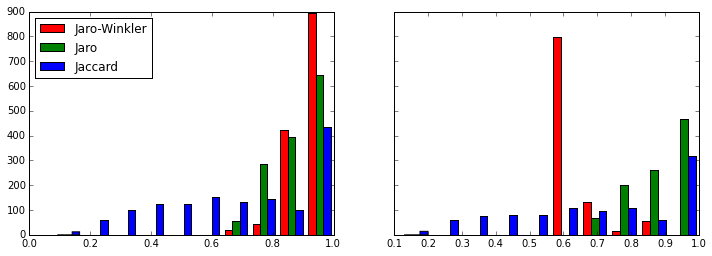

In [16]:
import jellyfish

df_m = pd.read_csv('./data/matched.csv')
df_u = pd.read_csv('./data/unmatched.csv')

df_m['jaro'] = df_m[['nname_x','nname_y']].apply(lambda s: jellyfish.jaro_distance(s[0],s[1]),axis=1)
df_m['jacc'] = df_m[['nname_x','nname_y']].apply(lambda s: jaccard(ngrams(s[0],2),ngrams(s[1],2)),axis=1)

df_u['jaro'] = df_m[['nname_x','nname_y']].apply(lambda s: jellyfish.jaro_distance(s[0],s[1]),axis=1)
df_u['jacc'] = df_m[['nname_x','nname_y']].apply(lambda s: jaccard(ngrams(s[0],2),ngrams(s[1],2)),axis=1)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_size_inches(12,4)
_=ax1.hist(df_m[['jw','jaro', 'jacc']].values, 
           color=['r', 'g', 'b'], 
           label=['Jaro-Winkler', 'Jaro', 'Jaccard'],
           histtype='bar')
_=ax1.legend(loc='upper left')
_=ax2.hist(df_u[['jw','jaro', 'jacc']].values, 
           color=['r', 'g', 'b'], 
           label=['Jaro-Winkler', 'Jaro', 'Jaccard'],
           histtype='bar')

The graph on the left shows similarity scores for names determined to be matched records, while the right graph shows the same metrics on the 1000 non-matches with the greatest similarity.  You can see that the Jaro-Winkler metric has the best ability to distinguish between matches and non-matches.

## Human Names

|  Name |  Source  |
| --- |  --- |
| RICHARD ALLAN BREGGER | Finra |
| RICHARD A BREGGER | DOL |
| BREGGER RICHARD A | DOL |
| RICHAPT) A BREGGER | DOL (OCR error) |
| RICHARD A BREGGER AXA FINANCIAL | DOL |
| RICHARD D BREGGER | DOL |
| RICHARDBREGGER | Record Keeper |

<img src='bregger.png'>

There are no human names in my test data, so i'll use an example from some financial advisor data.  The table above has several variations of a particular name that came from actual data sources.  It's fairly certain that these are all references to the same person.  The kicker is that if you search for this person on Google, the top result returned indicates that he actually goes by "Rick", not Richard.

### Stupid Human (Name) Tricks

- Almost always want to parse names into (first, middle or MI, last)
- Do not use regex
- Substituting first names is helpful, but build your own database of alternatives
- Do not use regex
- As you match, retain alternatives and do look-ups
- Sometimes worthwhile to match on a related item first, for example, employer.

Depending on the data source, human names will be either a single field, or separate fields for first, middle, and last names; plus maybe titles or suffixes.  For matching purposes it's almost always preferable to parse names given in a single field into the latter form.  It's usually preferable to use a specialized name parser for such a thing, rather than trying to roll your own with regular expressions.

One special situation with human names is the use of alternate first names (Rick, Mike, Maggie).  In many applications it's worthwhile to check these variants, however you have to be careful with existing first name alternative databases.  They often have dozens of extremely rare variations, so it's usually better to add the variations that are most likely.

Another complication with human names is that they change.  Often with surname changes or other significant name variations, the only way to match is to discover the relationship from other sources, and then keep a look-up table.

### The _nameparser_ library

In [17]:
from nameparser import HumanName

HumanName('DR. RICHARD ALLAN "Rick" BREGGER, Ph.D')

<HumanName : [
	title: 'DR.' 
	first: 'RICHARD' 
	middle: 'ALLAN' 
	last: 'BREGGER' 
	suffix: 'Ph.D'
	nickname: 'Rick'
]>

The _nameparser_ library is a good tool for parsing names in your own applications.  It does a very good job, even on complicated names provided that the format is not too bogus.

In [18]:
HumanName('BREGGER, RICHARD A')

<HumanName : [
	title: '' 
	first: 'RICHARD' 
	middle: 'A' 
	last: 'BREGGER' 
	suffix: ''
	nickname: ''
]>

In [19]:
HumanName('BREGGER RICHARD A')

<HumanName : [
	title: '' 
	first: 'BREGGER' 
	middle: 'RICHARD' 
	last: 'A' 
	suffix: ''
	nickname: ''
]>

However, it's not magical.  Since it relies primarily on certain syntactical elements, it won't get some common cases correct.  For instance, here it's relying on the comma to know that this name is in last name, first name order.

## Addresses and Geocoding

- Addresses are more frequently separated into multiple fields, usually street address, city, state, zip code in the source data.
- Zip codes have 3,5, and 9 (Zip+4) variants
- Since Zip codes are designed for efficiency of mail delivery, they aren't a consistent indicator of physical proximity.
  - Zips are not even areas
- The street number can be a useful identifier
- Different businesses might have identical addresses (aka, "the food-court effect")

Addresses are even tricker than human names, but there are two factors that help.  One is that addresses are most often already separated into multiple fields in data sources.  The other is that there's a long history of GIS research.  Zip codes, as in our test data, are often very useful on their own, but you do have to be careful with them since they really only describe mail delivery routes and not bounded geographical areas of any particular size.  Also note that having _identical_ addresses does not mean that two entities refer to the same thing.

In [20]:
df_fl_a[df_fl_a.location_address=='39 S BENEVA RD'][['dba',
                     'location_address',
                     'location_city',
                     'location_zip_code']]

,dba,location_address,location_city,location_zip_code
129483,HOSTED GOURMET,39 S BENEVA RD,SARASOTA,34232
129503,STAMPER CHEESE COMPANY,39 S BENEVA RD,SARASOTA,34232
129507,MOUTHOLE BBQ,39 S BENEVA RD,SARASOTA,34232
129515,PALEO CONNECTION LLC,39 S BENEVA RD,SARASOTA,34232
129516,DOLCE VITA LLC,39 S BENEVA RD,SARASOTA,34232
129517,BRICKS BBQ,39 S BENEVA RD,SARASOTA,34232
129521,WINGS ON WHEELS LLC,39 S BENEVA RD,SARASOTA,34232
130612,MOBILE BISTRO,39 S BENEVA RD,SARASOTA,34240
130625,RI QUISIMO,39 S BENEVA RD,SARASOTA,34232


For example...  Note also that one of these items has a different zip code, which tells us that we can't always rely on zip codes being correct.

### Geocoders

Geocoding is translating an address into latitude and longitude.

- Google
- OpenStreetMap Nominatim
- geocoder.us
- TIGER
  - Addon for PostGIS
  - Uses US Census Bureau TIGER Geodatabases

Geocoders can be very useful with address data if it is of sufficiently good quality.  Their main purpose is to translate an address in to latitude and longitude (or vice versa); but they have a side-benefit of tokenizing address components.  There are numerous geo-coding services some of which are listed here, however many of them cost money, which can be a problem if you have millions of addresses to handle.  One "free" option is the TIGER geocoder, which is part of the PostGIS addon for Postgres.

```
SELECT g.rating, ST_X(g.geomout) As lon, ST_Y(g.geomout) As lat, 
(addy).address As stno, (addy).streetname As street, 
(addy).streettypeabbrev As styp, (addy).location As city, (addy).stateabbrev As st,(addy).zip 
FROM geocode('555 Lake Border Drive, Apopka, FL 32703') As g; 

 rating |        lon        |       lat        | stno |   street    | styp |  city  | st |  zip  
--------+-------------------+------------------+------+-------------+------+--------+----+-------
      0 | -81.4651538792139 | 28.6714046741846 |  555 | Lake Border | Dr   | Apopka | FL | 32703
```

| Address | Rating | Street # | Longitude | Latitude |
| ------- | ------ | --------- | -------- |
| 555 Lake Border Drive, Apopka, FL 32703| <span style="color:blue">0</span> | 555 | -81.4651538792139 | 28.6714046741846 |
| 5555 Lake Border Drive, Apopka, FL 32703| <span style="color:blue">10</span> | <span style="color:red">699</span> | -81.4651087639419 | 28.6712609342955 |
| Apopka, FL 32703| <span style="color:blue">100</span> || -81.552957384847 | 28.6706870842484 |

The top part of this slide shows how you can invoke the TIGER geocoder from psql.  Obviously, you can put a Python wrapper around this fairly trivially, although there are also sophisticated tools like GeoDjango that you can use.

Note that geocoders are only as good as the data passed in.  Usually the return value of a geocoder will included an indicator of the quality of the data.  The table here shows three different addresses and their associated ratings.  The first is a correct address that the geocoder can identify precisely.  The second is an incorrect address, and so the geocoder makes a best guess on the intended address.  The third item has only the city and zip, so the geocoder can only return latitude and longitude for some reference position within that zip code.

#### Comparing Locations

- To compute actual _distance_ you need to use Vincenty or Great Circle distance
- However for comparison, L1 norm will probably work.

In [21]:
from geopy.distance import vincenty

l0 = (-81.4651538792139,  28.6714046741846)
l10 = (-81.4651087639419, 28.6712609342955)
l100 = (-81.552957384847,  28.6706870842484)

vincenty(l0, l10).miles, vincenty(l0, l100).miles

(0.0034628723732747875, 6.092525294476887)

If you want to calculate the precise distance between points, you have to use a calculation like the Great Circle distance that takes into account that you're moving along a curved surface.  However, in matching you can often just subtract the component parts and sum them (ie the L1 norm).

Here i'm using the geopy library to calculate the distances between the points we found above.  Note that the distance between the correct address and the zip-only address is 6 miles.

## Blocking

 __Blocking__ is the process of reducing the number of candidate pairs by assiging the records in each data set to a block.  Only record pairs that have the same block key will be compared.

For example, here's a case using the _soundex_ value of the name as the blocking key:

In [22]:
df_fl_a['sndx'] = df_fl_a.nname.apply(jellyfish.soundex)
df_oge_a_fl['sndx'] = df_oge_a_fl.nname.apply(jellyfish.soundex)
df_fl_a[df_fl_a.sndx=='g262'].merge(df_oge_a_fl[df_oge_a_fl.sndx=='g262'], on='sndx')[['nname_x','nname_y','sndx']]

,nname_x,nname_y,sndx
0,g & c restaurant,g.w. sharkeys raw bar & grill,g262
1,g & c restaurant,"gasca, rosendo h. flc",g262
2,g & c restaurant,geysers international inc,g262
3,g & c restaurant,"geysers international, inc.",g262
4,gayou's restaurant,g.w. sharkeys raw bar & grill,g262
5,gayou's restaurant,"gasca, rosendo h. flc",g262
6,gayou's restaurant,geysers international inc,g262
7,gayou's restaurant,"geysers international, inc.",g262
8,geiger key marina and fish camp,g.w. sharkeys raw bar & grill,g262
9,geiger key marina and fish camp,"gasca, rosendo h. flc",g262


Blocking is the process of reducing the number of record pairs that need to be compared.  Our example case has over 800 million record pairs in A x B. That's not huge by today's standards, but you can see that the larger our data sets get, the more we want to eliminate record pairs.  Above is shown a traditional method for blocking, where records in the two data sets are _candidates_ if they have the same soundex value.  Soundex is a code that's supposed to indicate strings that begin with similar sounds.

### Using a Single Property

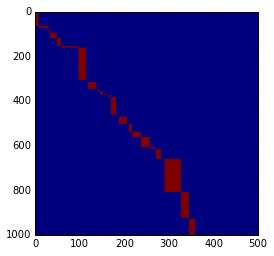

In [23]:
df_fl_a['k'] = 1
df_oge_a_fl['k'] = 1
df_block = df_fl_a.sort_values(by='nzip').iloc[0:1000].merge(df_oge_a_fl.sort_values(by='nzip').iloc[0:500], 
                                                             on='k')[['nzip_x', 'nzip_y']]

z = (df_block.nzip_x == df_block.nzip_y).values
z.shape = (1000, 500)
_=plt.imshow(z, aspect=0.5)

Sometimes you can simply use a single property in the data (or part of it) to block. For example, the red section above shows the pairs we would retain if we only used records where the 5-digit zip matches.  However as we've seen there are some wrong zips so this would miss matches.  You could also use the first 3 digits of the zip to throw a wider net.

### Using Multiple Properties

- Blocking with an existing property will often defeat the purpose of matching
- Using multiple properties (eg, Zip, Street Num) increases the probability of including candidates
  - At the expense of __multiple blocks per record__.
- This is equivalent to Locality Sensitive Hashing (LSH)

The idea here is that you sort by the first property and consider pairs where the property matches as we did with zip above, then you sort by the second property and compare any pairs not already considered.  Each new property reduces the probability of dropping a record pair with a match.

### N-Gram Based Blocks

In [24]:
def window(fseq, window_size=8):
    for i in range(len(fseq) - window_size + 1):
        yield fseq[i:i+window_size]

#Find bigrams and then join them into 8-bigram keys
n1 = ngrams('mainstreet cafe', 2)
[''.join(x) for x in window(n1)]
n2 = ngrams('the main street cafe inc', 2)
# Find the keys shared by these two names
set([''.join(x) for x in window(n1)]) & set([''.join(x) for x in window(n2)])

{'reeeett  ccaaffe', 'sttrreeeett  cca', 'trreeeett  ccaaf'}

This approach works well with messier name data.  For example in this case we have two names that are in fact a match, but they don't have a high similarity score or the same soundex code.  What we do is form bigrams from the names, and then make blocking keys by joining a subset of the bigrams into strings.  You can see here that these two names share 3 blocking keys, so they would end up in the same index lists.

### Canopy Clustering

Canopy clustering is a sort of "pre-clustering" used to reduce the number of comparisons needed in more complex clustering algorithms

- Generate blocking keys for records in both data sets (for example, n-grams of name)
- Build an inverted index (eg, n-gram to list of records with that n-gram)
- Repeat
  - Choose a random record to make a new "canopy"
  - Look up matching records in inverted index
  - For each record in index, calculate 

## Classifying Matches

We can now generate the comparison vectors:

$$
[s_{1}(a_{1}, b_{1}), ..., s_{n}(a_{n}, b_{n})]
$$

Options:
 - Simple Scoring
 - Rules
 - Probabilistic matching
 - Supervised learning

So now we know how to compare fields, and we know how to limit the record pairs that we want to compare, so we can create the comparison vectors.  There are several ways to use that information to classify each record pair as a match or non-match.  The first is just calculating a simple score

### Simple Scoring



$$
Score(r_{a}, r_{b}) = \sum_{i=1}^{n} w_{i} s_{i}(a_{i}, b_{i})
$$

$$ 
Score(r_{a}, r_{b}) > T \implies r \in M
$$

- Sum the individual scores and set a threshold T1.  Anything > T1 is a match
- For bonus points, choose a second threshold T2 so that anything < T2 is a non-match
- Any sum between T1 and T2 needs review.


The easiest way to classify matches is just to form a score from the components of the comparison vector usually by summing them, possibly with unequal weights.  In fact, this is simple enough that it can usually be calculated directly from the record pairs.

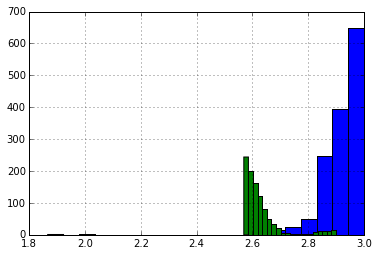

In [25]:
def match_score(r_a, r_b):
    return (jellyfish.jaro_winkler(r_a[0], r_b[0]) + 
            (1.0 if r_a[1] == r_b[1] else 0) + 
            (1.0 if r_a[2] == r_b[2] else 0))

_=df_m[['nname_x','snum_x', 'nzip', 
        'nname_y', 'snum_y', 'nzip']].apply(
       lambda r: match_score(r[0:3], r[3:]), axis=1).hist(bins=20)
_=df_u[['nname_x','snum_x', 'nzip', 
        'nname_y', 'snum_y', 'nzip']].apply(
       lambda r: match_score(r[0:3], r[3:]), axis=1).hist(bins=20)

This approach actually works reasonably well on our example even using a super-simple score.  This graph shows the scores of the true matches (in blue) and the scores of the top 1000 non-matches.  They are fairly well separated except for some outliers down at the bottom that were manually set.  However, there's a range between 2.7 and 2.9 where there are numerous matches and non-matches.

### Rules

$$
(JaroWinkler(Name_{A}, Name_{B}) > 0.9) \land (Zip_{A} = Zip_{B}) \implies M
$$

$$
(JaroWinkler(Name_{A}, Name_{B}) < 0.7) \lor (Zip_{A} \neq Zip_{B}) \implies U
$$


Using rules is another common approach. Basically we're just applying various conditions to the elements of the comparison vector.  The rules are usually just implemented with standard Python conditionals, but you could also use something like PyRules for complicated situations.  Rules give us an added level of complexity over scoring.  For example, we could have one rule that says we have a match if the Jaro-Winkler score is 0.8 and the zip and street number match, and another rule that says we have a match if the names are identical and the street number matches.  The biggest problem with rules is that they are harder to learn, so you often need experience with the data or the problem domain before you can get them right.

### Probabilistic Matching (Fellegi-Sunter)

Suppose our comparison vector is:

$$
  \gamma(r_{A}, r_{B}) = [JaroWinkler(Name_{A}, Name_{B}) > 0.9, (Zip_{A} = Zip_{B}), Levenshtein(StreetNum_{A}, StreetNum_{B}) < 2]
$$

We'll call this type of comparison vector an _agreement pattern_.  The are 8 separate patterns (2^3) in this case


In [26]:
import itertools
pd.DataFrame(data=list(itertools.product(['match','unmatch'], repeat=3)),
             columns=['name', 'zip', 'street num'])

,name,zip,street num
0,match,match,match
1,match,match,unmatch
2,match,unmatch,match
3,match,unmatch,unmatch
4,unmatch,match,match
5,unmatch,match,unmatch
6,unmatch,unmatch,match
7,unmatch,unmatch,unmatch


Probabilistic matching methods, which are mostly identified with the method of Fellegi and Sunter, were the first attempts to find an optimal approach to matching.  The starting point is a comparison vector that is a set of predicates, or an _agreement pattern_, here called gamma.  Fellegi and Sunter treat gamma as a random variable, so that each pattern has a certain probability of occuring in the set of pairs, and of course the probability of all the patterns sums to one.  Certain patterns will obviously be much more associated with matches, and others will be much more associated with non-matches.

The method then defines the following two conditonal probabilities:

$$
\begin{align}
m(\gamma) = P[\gamma(r_{A}, r_{B})| (r_{A}, r_{B}) \in M] \\
\end{align}
$$
and
$$
\begin{align}
u(\gamma) = P[\gamma(r_{A}, r_{B})| (r_{A}, r_{B}) \in U] \\
\end{align}
$$


To capture this idea, they first define two conditional probabilities: m, the probability that a certain pattern will occur in the set of matches, and u the probability that a pattern will appear in the set of non-matches.

The Fellegi-Sunter method results in a _linkage rule_:

$$
	\begin{array}{ll}
		\frac{m}{u} > T_{\mu}  & \mbox{match}  \\
        T_{\mu} < \frac{m}{u} < T_{\lambda}  & \mbox{potential match}  \\
		\frac{m}{u} < T_{\lambda}  & \mbox{non-match}  \\
	\end{array}
$$


Using ratios of m and u, the method defines a _linkage rule_, which uses two thresholds to define matches, possible matches, and non-matches.  The insight of Fellegi and Sunter was that if you sort the m/u ratios from largest to smallest you can define a linkage rule that will give you the best possible match set given the data and the level of error that you're willing to accept.  Obviously, you want to mimimize the "potential match" range so that the process is as automatic as possible, but you have to do so while not introducing false positives or missing true matches.

#### Simplifications

- Conditional Independence

$$
\begin{align}
& P(\textit{name matches}, \textit{zip matches}, \textit{street matches}|M) = \\
& P(\textit{name matches}|M) P(\textit{zip matches}|M) P(\textit{street matches}|M) \\
\end{align}
$$

- So

$$
m(\textit{name matches}) = \frac{P(\textit{name matches}|M)}{P(\textit{name matches}|U)}
$$

Two simplifications are usually introduced for the method.  The first is to assume conditional independence between the properties, so that the probabilities of each pattern conditional on M can be written as the product of the probabilities for the individual attributes.

- Convert m/u ratios to weights:

$$
w_{i} = 
\left\{
	\begin{array}{ll}
		log_{2}(\frac{m_{i}}{u_{i}})  & \mbox{if agreement on field i}  \\
		log_{2}(\frac{1-m_{i}}{1-u_{i}}) & \mbox{if otherwise}
	\end{array}
\right.
$$

Once conditional independence is assumed you can also convert the ratios to a log form and then score each record with a sum rather than a product.

### But Wait!


- By definition we don't know which records are in M and which are in U
- In some cases __m/u__ can be estimated, and then progressively refined.
- Most general method is __Expectation-Maximization__ algorithm

Obviously the conditional probabilities we defined above require knowing which records are in M and which are in U, but we could only know that for sure by actually determining the matches.  Fortunately there is a well-known way to estimate the parameters given our data that's based on the idea of maximum likelihood estimation, which is a way to find the values of distribution parameters that are the most likely given the data that we have.  The data that we do have is the comparison vectors and agreement patterns.  The data that we don't have is whether each record is in M or in U.  That's where the Expectation-Maximization algorithm comes in.

- Assume distribution of patterns is a mixture of distributions, with parameters:

$$
\Phi = ((m_{1}\dots m_{k}), (u_{1}\dots u_{k}), p)
$$

- Also assume there is a _latent variable_ __g__ that determines whether a record pair is in __M__ or __U__.  Then the likelihood function for the data we have is:


$$
f(g,\gamma; \Phi) = \prod_{j=1}({pP(\gamma_{j}|r_{j} \in M))^g((1-p)P(\gamma_{j}|r_{j} \in U)})^{(1-g)}
$$

where the product is over the _j_ attributes we're comparing.

The E-M algorithm is a sort of unsupervised classification or clustering.  We start by assuming that the overall distribution of our data is a _mixture_ of two distributions, given by the m and u values, and an additional parameter p that describes the probability that a record is a match.  This is also sometimes called the _mixing parameter_.  This is the same method used in Scikit-learn's Gaussian Mixture Models, except here the distributions we're mixing are not gaussian.

The next detail of the E-M approach is the assumption of a latent variable, g, that says whether or not the record is in the match set or not.  Of course we don't know this, which is why it is hidden or latent.  The hairy-looking function above is the _likelihood function_ for our data including the latent variable.  We can't easily maximize this directly, so the E-M algorithm takes an iterative approach.

The E-M algorithm starts with initial estimates of the m, u, and p parameters; along with the agreement patterns.  It first calculates the expected value of g for each record.  Then it uses those values to calculate new values for m, u, and p.  This is repeated until the parameters don't change, within some threshold.

In [27]:
import operator
import numpy as np
from functools import reduce

mh = np.array([ 0.08910887,  0.98090761,  0.88638131])
uh = np.array([ 0.00019569,  0.00198455,  0.0003152 ])

def mp(gamma, mh, uh):
    return reduce(operator.mul, (mh[i] ** g * (1 - mh[i]) ** (1 - g) for i,g in enumerate(gamma)))

def up(gamma, mh, uh):
    return reduce(operator.mul, (uh[i] ** g * (1 - uh[i]) ** (1 - g) for i,g in enumerate(gamma)))

def log_score(gamma, mh, uh):
    return sum([np.log2(mh[i]/uh[i]) if g==1 else np.log2((1-mh[i])/(1-uh[i])) for i,g in enumerate(gamma)])

In [28]:
df_scores = pd.DataFrame(data=list(itertools.product([1,0], repeat=3)),
             columns=['name', 'zip', 'street num'])
df_scores['m'] = df_scores[['name', 'zip', 'street num']].apply(lambda p: mp(p,mh,uh), axis=1)
df_scores['u'] = df_scores[['name', 'zip', 'street num']].apply(lambda p: up(p,mh,uh), axis=1)
df_scores['mu'] = df_scores.m/df_scores.u
df_scores['w'] = df_scores[['name', 'zip', 'street num']].apply(lambda p: log_score(p,mh,uh), axis=1)
df_scores.sort_values(by='mu', ascending=False, inplace=True)
df_scores['cu'] = df_scores.u.cumsum()
df_scores['cm'] = df_scores.m.cumsum()
HTML(df_scores.to_html(classes='potential'))

,name,zip,street num,m,u,mu,w,cu,cm
0,1,1,1,0.077476,1.224100e-10,6.329257e+08,29.237461,1.224100e-10,0.077476
4,0,1,1,0.791982,6.254078e-07,1.266345e+06,20.272239,6.255302e-07,0.869458
1,1,1,0,0.009931,3.882342e-07,2.558027e+04,14.642744,1.013764e-06,0.879389
2,1,0,1,0.001508,6.155908e-08,2.449682e+04,14.580307,1.075323e-06,0.880897
5,0,1,0,0.101518,1.983536e-03,5.118046e+01,5.677521,1.984612e-03,0.982416
6,0,0,1,0.015415,3.145129e-04,4.901273e+01,5.615085,2.299124e-03,0.997831
3,1,0,0,0.000193,1.952401e-04,9.900612e-01,-0.014410,2.494365e-03,0.998024
7,0,0,0,0.001976,9.975056e-01,1.980894e-03,-8.979633,1.000000e+00,1.000000


The data above shows m and u data calculated for our test set, using only name, zip, and street number for comparison.  These are sorted by m/u ratio.  This doesn't give us great results.  Only the first ratio is really safe in terms of automatically declaring a match.  The last 4 are also pretty safe in terms of determining a non-match.  However the three patterns show in yellow probably need some review.  It might not seem like it at first-- note that for the second pattern the u value is only about 1 in a million, but also recall that we're thinking in terms of 900 million pairs.

In [29]:
Javascript('''$('.potential tbody tr').filter(':eq(1)')
                                             .css('background-color', '#ffff99');
              $('.potential tbody tr').filter(':eq(2)')
                                             .css('background-color', '#ffff99');
              $('.potential tbody tr').filter(':eq(3)')
                                             .css('background-color', '#ffff99');                                             
                   ''')

<IPython.core.display.Javascript object>

### Supervised Learning

- Requires training data where matches/non-matches are already known
- Always imbalanced since there are many more non-matches than matches
- Harder to apply in production situations

If you have some data that already has matches defined, that can be used to train the standard classifiers in scikit-learn.  This might seem unlikely, but it's not unusual to use one of the techniques above in conjunction with a team of reviewers to determine the likely matches.  

In this case our comparison vector will correspond to a feature vector.  Note that the classes will always be unbalanced, that is we'll always have way more non-matches than matches.

In [30]:
import numpy as np
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier

df_train = pd.read_csv('./data/match_train.csv')

#Make some new features
df_train['jw_dist'] = df_train[['snum_x', 'snum_y']].apply(
                            lambda s: jellyfish.jaro_winkler(str(s[0]), str(s[1])),
                            axis=1)
df_train['snum_dist'] = df_train[['snum_x', 'snum_y']].apply(
                            lambda s: levenshtein_distance(str(s[0]), str(s[1])),
                            axis=1)
df_train['city_sim'] = df_train[['cty_nm', 'location_city']].apply(
                            lambda c: jaccard( ngrams(c[0].lower(),2),
                                               ngrams(c[1].lower(),2)),
                                               axis=1)
#Make a balanced data set
df_matched = df_train[df_train.match==1]
df_unmatched = df_train[df_train.match==0]
df_bal = pd.concat( [df_matched, 
                     df_unmatched.sample(len(df_matched)) ] ).reset_index()

0.994557329463


C:\Users\mike\Anaconda\envs\matching\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


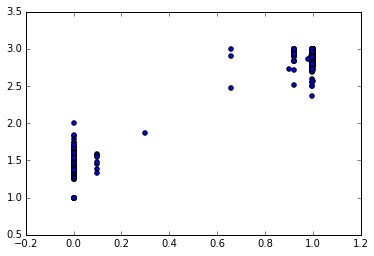

In [52]:
df_bal = pd.read_csv('./data/balanced_train.csv')

# Do a 5-fold cross-validation
y = df_bal.match
X = df_bal[['jw_dist', 'snum_dist', 'city_sim']].as_matrix()

kf = KFold(len(y),n_folds=5,shuffle=True)
y_pred = y.copy()

clf = RandomForestClassifier()

# Iterate through folds
for train_index, test_index in kf:
    X_train, X_test = X[train_index], X[test_index]
    y_train = y[train_index]
    # Initialize a classifier with key word arguments

    clf.fit(X_train,y_train)
    y_pred[test_index] = clf.predict(X_test)

print(np.mean(y == y_pred))
df_bal['nzip'] = 1
yy=df_bal[['nname_x','snum_x', 'nzip', 
        'nname_y', 'snum_y', 'nzip']].apply(
       lambda r: match_score(r[0:3], r[3:]), axis=1).values
xx =          clf.predict_proba(X)
plt.scatter(xx[:,1],yy)

As an example, here's a case where i've built a balanced data set by just randomly choosing as many non-matches as i have matches, then i do a 5-fold cross-validation using a Random Forest Classifier.  The predicted value is correct here about 99% of the time.

## Active Learning and _Dedupe_

_PAUSE FOR DEMO_

## Information Quality Metrics for Matching

- Number of References
- Class statistics: size, max
- Talburt-Wang Index
- Rand Index


In [51]:
xx[:,1]

array([ 0.99377586,  0.99377586,  0.99377586, ...,  0.        ,
        0.        ,  0.        ])